In [1]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool
from imblearn.combine import SMOTETomek
from tabpfn import TabPFNClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import lightgbm as lgb
import pandas as pd
import numpy as np
import random
import time

# configs
random.seed(18)
np.random.seed(18)
pd.set_option("display.max_column", 35)

# Routines

In [2]:
# LABEL_ENCODERS = dict()

# def dataCleaning(data: pd.DataFrame) -> pd.DataFrame:
  
#   # make all columns to lower case
#   data.columns = data.columns.str.lower()

#   # make all data to be lower case
#   data = data.apply(lambda col: col.str.lower() if col.dtype == 'object' else col )

#   # drop columns
#   # if 'ID' in data.columns: data.drop(columns=['ID'], inplace=True)

#   if 'country_id' in data.columns.values:
#     data.drop(columns=['country_id'], inplace=True)

#   # date columns
#   date_cols = ['disbursement_date', 'due_date']
#   for col in date_cols:
#     data[col] = pd.to_datetime(data[col])
#     # extract month, day, and year from the date columns
#     data[col+'_month'] = data[col].dt.month
#     data[col+'_day'] = data[col].dt.day
#     data[col+'_year'] = data[col].dt.year

#   # drop the dates columns
#   data.drop(columns=date_cols, inplace=True)

#   # encode object columns
#   for column_name in data[['loan_type', 'new_versus_repeat']]:
#     le = LabelEncoder()
#     data[f"{column_name}_cat"] = le.fit_transform(data[column_name])
#     LABEL_ENCODERS[column_name] = le

#   return data


LENDER_ID_MAP = {
  267278: 0, 
  251804: 1, 
  245684: 2, 
  267277: 3
}

LENDER_ID_MAP_REV = {
  0: 267278, 
  1: 251804, 
  2: 245684, 
  3: 267277
}

DURATION_BINS_MAP = {
  'short-term': 0, 
  'medium-term': 1, 
  'very-long-term': 2, 
  'long-term': 3
}

DURATION_BINS_MAP_REV = {
  0: 'short-term', 
  1: 'medium-term', 
  2: 'very-long-term', 
  3: 'long-term'
}

def timeNow():
  now = datetime.now()
  # Extract the current hour, minute, and date
  hour = now.hour
  minute = now.minute
  date = now.date()
  return f"{hour}:{minute}-{date}"


timeNow()

'22:0-2025-02-02'

# Data Loading

In [3]:
# training data
df = pd.read_csv("./african-credit-scoring-challenge/Train.csv")
df

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0
2,ID_308486370501251804,308486,Kenya,370501,251804,Type_7,6900.0,7142.0,2024-09-06,2024-09-13,7,Repeat Loan,1380.00,0.200000,1428.0,0
3,ID_266004285009267278,266004,Kenya,285009,267278,Type_1,8958.0,9233.0,2022-10-20,2022-10-27,7,Repeat Loan,2687.40,0.300000,2770.0,0
4,ID_253803305312267278,253803,Kenya,305312,267278,Type_1,4564.0,4728.0,2022-11-28,2022-12-05,7,Repeat Loan,1369.20,0.300000,1418.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68649,ID_244559228408267278,244559,Kenya,228408,267278,Type_1,1460.0,1515.0,2022-07-30,2022-08-06,7,Repeat Loan,438.00,0.300000,455.0,0
68650,ID_260062217784267278,260062,Kenya,217784,267278,Type_1,5029.0,5116.0,2022-07-16,2022-07-23,7,Repeat Loan,1508.70,0.300000,1535.0,0
68651,ID_259137216701267278,259137,Kenya,216701,267278,Type_1,5289.0,5289.0,2022-07-15,2022-07-22,7,Repeat Loan,1586.70,0.300000,1587.0,0
68652,ID_266801303201267278,266801,Kenya,303201,267278,Type_1,3334.0,3334.0,2022-11-23,2022-11-30,7,Repeat Loan,741.09,0.222283,741.0,0


In [4]:
df['loan_type'].unique()

array(['Type_1', 'Type_7', 'Type_5', 'Type_4', 'Type_6', 'Type_14',
       'Type_9', 'Type_10', 'Type_19', 'Type_16', 'Type_2', 'Type_11',
       'Type_23', 'Type_18', 'Type_17', 'Type_12', 'Type_20', 'Type_13',
       'Type_21', 'Type_15', 'Type_24', 'Type_22'], dtype=object)

In [5]:
df['country_id'].value_counts()

country_id
Kenya    68654
Name: count, dtype: int64

In [6]:
df.columns

Index(['ID', 'customer_id', 'country_id', 'tbl_loan_id', 'lender_id',
       'loan_type', 'Total_Amount', 'Total_Amount_to_Repay',
       'disbursement_date', 'due_date', 'duration', 'New_versus_Repeat',
       'Amount_Funded_By_Lender', 'Lender_portion_Funded',
       'Lender_portion_to_be_repaid', 'target'],
      dtype='object')

In [7]:
# 
test_df = pd.read_csv("./african-credit-scoring-challenge/Test.csv")
print(test_df.shape)
test_df.head(2)

(18594, 15)


,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid
0,ID_269404226088267278,269404,Kenya,226088,267278,Type_1,1919.0,1989.0,2022-07-27,2022-08-03,7,Repeat Loan,575.7,0.3,597.0
1,ID_255356300042267278,255356,Kenya,300042,267278,Type_1,2138.0,2153.0,2022-11-16,2022-11-23,7,Repeat Loan,0.0,0.0,0.0


In [8]:
test_df.columns

Index(['ID', 'customer_id', 'country_id', 'tbl_loan_id', 'lender_id',
       'loan_type', 'Total_Amount', 'Total_Amount_to_Repay',
       'disbursement_date', 'due_date', 'duration', 'New_versus_Repeat',
       'Amount_Funded_By_Lender', 'Lender_portion_Funded',
       'Lender_portion_to_be_repaid'],
      dtype='object')

In [9]:
test_df['loan_type'].unique()

array(['Type_1', 'Type_7', 'Type_3', 'Type_2', 'Type_10', 'Type_6',
       'Type_23', 'Type_14', 'Type_5', 'Type_4', 'Type_17', 'Type_9',
       'Type_12', 'Type_8', 'Type_11', 'Type_18', 'Type_24', 'Type_22',
       'Type_20', 'Type_15', 'Type_21', 'Type_13'], dtype=object)

In [10]:
test_df['country_id'].value_counts()

country_id
Kenya    15069
Ghana     3525
Name: count, dtype: int64

# Data Cleaning

In [11]:
df.head(2)

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0


### Drop Column

In [12]:
# to delete : country_id, ID, 
df.drop(columns=['ID', 'country_id'], inplace=True)
df.head(2)

,customer_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,266671,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0
1,248919,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0


In [13]:
# test_df.drop(columns=['country_id'], inplace=True)
test_df.head(2)

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid
0,ID_269404226088267278,269404,Kenya,226088,267278,Type_1,1919.0,1989.0,2022-07-27,2022-08-03,7,Repeat Loan,575.7,0.3,597.0
1,ID_255356300042267278,255356,Kenya,300042,267278,Type_1,2138.0,2153.0,2022-11-16,2022-11-23,7,Repeat Loan,0.0,0.0,0.0


### Normalise Columns
- lower case
- datatime columns

In [14]:
# make columns and data to lower case
df.columns = df.columns.str.lower()
df = df.apply(lambda col: col.str.lower() if col.dtype == 'object' else col )

In [15]:
# test_df.dtypes - test data
test_df.columns = test_df.columns.str.lower()
test_df = test_df.apply(lambda col: col.str.lower() if col.dtype == 'object' else col )
test_df.columns

Index(['id', 'customer_id', 'country_id', 'tbl_loan_id', 'lender_id',
       'loan_type', 'total_amount', 'total_amount_to_repay',
       'disbursement_date', 'due_date', 'duration', 'new_versus_repeat',
       'amount_funded_by_lender', 'lender_portion_funded',
       'lender_portion_to_be_repaid'],
      dtype='object')

In [16]:
# training data
date_cols = ['disbursement_date', 'due_date']
for col in date_cols:
  df[col] = pd.to_datetime(df[col])
  # Extract month, day, and year from the date columns
  df[col+'_month'] = df[col].dt.month
  df[col+'_day'] = df[col].dt.day
  df[col+'_year'] = df[col].dt.year

# drop the dates columns
df.drop(columns=date_cols, inplace=True)

df.head(2)

,customer_id,tbl_loan_id,lender_id,loan_type,total_amount,total_amount_to_repay,duration,new_versus_repeat,amount_funded_by_lender,lender_portion_funded,lender_portion_to_be_repaid,target,disbursement_date_month,disbursement_date_day,disbursement_date_year,due_date_month,due_date_day,due_date_year
0,266671,248032,267278,type_1,8448.0,8448.0,7,repeat loan,120.85,0.014305,121.0,0,8,30,2022,9,6,2022
1,248919,228515,267278,type_1,25895.0,25979.0,7,repeat loan,7768.50,0.300000,7794.0,0,7,30,2022,8,6,2022


In [17]:
print(df['disbursement_date_year'].unique())
print(df['due_date_year'].unique())

[2022 2024 2023 2021]
[2022 2024 2023 2025 2021]


In [18]:
# test data
date_cols = ['disbursement_date', 'due_date']
for col in date_cols:
  test_df[col] = pd.to_datetime(test_df[col])
  # Extract month, day, and year from the date columns
  test_df[col+'_month'] = test_df[col].dt.month
  test_df[col+'_day'] = test_df[col].dt.day
  test_df[col+'_year'] = test_df[col].dt.year

# drop the dates columns
test_df.drop(columns=date_cols, inplace=True)

test_df.head(2)

,id,customer_id,country_id,tbl_loan_id,lender_id,loan_type,total_amount,total_amount_to_repay,duration,new_versus_repeat,amount_funded_by_lender,lender_portion_funded,lender_portion_to_be_repaid,disbursement_date_month,disbursement_date_day,disbursement_date_year,due_date_month,due_date_day,due_date_year
0,id_269404226088267278,269404,kenya,226088,267278,type_1,1919.0,1989.0,7,repeat loan,575.7,0.3,597.0,7,27,2022,8,3,2022
1,id_255356300042267278,255356,kenya,300042,267278,type_1,2138.0,2153.0,7,repeat loan,0.0,0.0,0.0,11,16,2022,11,23,2022


In [19]:
print(df['disbursement_date_year'].unique())
print(df['due_date_year'].unique())

[2022 2024 2023 2021]
[2022 2024 2023 2025 2021]


In [20]:
# a copy of the dataframe
train_df = df.copy(deep=True)

### Columns Encoding

In [21]:
test_df.isnull().sum().to_frame().T

,id,customer_id,country_id,tbl_loan_id,lender_id,loan_type,total_amount,total_amount_to_repay,duration,new_versus_repeat,amount_funded_by_lender,lender_portion_funded,lender_portion_to_be_repaid,disbursement_date_month,disbursement_date_day,disbursement_date_year,due_date_month,due_date_day,due_date_year
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
df.isnull().sum().to_frame().T

,customer_id,tbl_loan_id,lender_id,loan_type,total_amount,total_amount_to_repay,duration,new_versus_repeat,amount_funded_by_lender,lender_portion_funded,lender_portion_to_be_repaid,target,disbursement_date_month,disbursement_date_day,disbursement_date_year,due_date_month,due_date_day,due_date_year
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
LABEL_ENCODERS = dict()
# 
for column_name in df[['loan_type', 'new_versus_repeat']]:
  le = LabelEncoder()
  df[f"{column_name}_cat"] = le.fit_transform(df[column_name])
  test_df[f"{column_name}_cat"] = le.fit_transform(test_df[column_name])
  LABEL_ENCODERS[column_name] = le

In [24]:
df.head(2)

,customer_id,tbl_loan_id,lender_id,loan_type,total_amount,total_amount_to_repay,duration,new_versus_repeat,amount_funded_by_lender,lender_portion_funded,lender_portion_to_be_repaid,target,disbursement_date_month,disbursement_date_day,disbursement_date_year,due_date_month,due_date_day,due_date_year,loan_type_cat,new_versus_repeat_cat
0,266671,248032,267278,type_1,8448.0,8448.0,7,repeat loan,120.85,0.014305,121.0,0,8,30,2022,9,6,2022,0,1
1,248919,228515,267278,type_1,25895.0,25979.0,7,repeat loan,7768.50,0.300000,7794.0,0,7,30,2022,8,6,2022,0,1


In [25]:
test_df.head(2)

,id,customer_id,country_id,tbl_loan_id,lender_id,loan_type,total_amount,total_amount_to_repay,duration,new_versus_repeat,amount_funded_by_lender,lender_portion_funded,lender_portion_to_be_repaid,disbursement_date_month,disbursement_date_day,disbursement_date_year,due_date_month,due_date_day,due_date_year,loan_type_cat,new_versus_repeat_cat
0,id_269404226088267278,269404,kenya,226088,267278,type_1,1919.0,1989.0,7,repeat loan,575.7,0.3,597.0,7,27,2022,8,3,2022,0,1
1,id_255356300042267278,255356,kenya,300042,267278,type_1,2138.0,2153.0,7,repeat loan,0.0,0.0,0.0,11,16,2022,11,23,2022,0,1


### Normalise Numeric Columns

In [26]:
df.head(2)

,customer_id,tbl_loan_id,lender_id,loan_type,total_amount,total_amount_to_repay,duration,new_versus_repeat,amount_funded_by_lender,lender_portion_funded,lender_portion_to_be_repaid,target,disbursement_date_month,disbursement_date_day,disbursement_date_year,due_date_month,due_date_day,due_date_year,loan_type_cat,new_versus_repeat_cat
0,266671,248032,267278,type_1,8448.0,8448.0,7,repeat loan,120.85,0.014305,121.0,0,8,30,2022,9,6,2022,0,1
1,248919,228515,267278,type_1,25895.0,25979.0,7,repeat loan,7768.50,0.300000,7794.0,0,7,30,2022,8,6,2022,0,1


In [27]:
test_df.head(2)

,id,customer_id,country_id,tbl_loan_id,lender_id,loan_type,total_amount,total_amount_to_repay,duration,new_versus_repeat,amount_funded_by_lender,lender_portion_funded,lender_portion_to_be_repaid,disbursement_date_month,disbursement_date_day,disbursement_date_year,due_date_month,due_date_day,due_date_year,loan_type_cat,new_versus_repeat_cat
0,id_269404226088267278,269404,kenya,226088,267278,type_1,1919.0,1989.0,7,repeat loan,575.7,0.3,597.0,7,27,2022,8,3,2022,0,1
1,id_255356300042267278,255356,kenya,300042,267278,type_1,2138.0,2153.0,7,repeat loan,0.0,0.0,0.0,11,16,2022,11,23,2022,0,1


train data: 2021 2022.104014332741 2024
test data: 2021 2022.1031515542647 2024


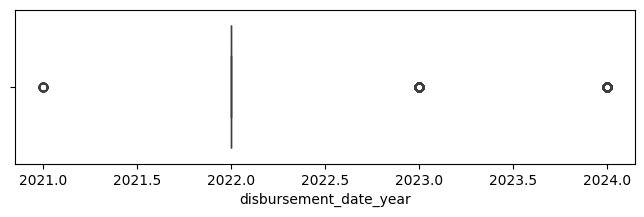

In [28]:
# outliers
colName = 'disbursement_date_year'
print("train data:",df[colName].min(), df[colName].mean(), df[colName].max())
print("test data:", test_df[colName].min(),test_df[colName].mean(), test_df[colName].max())
# 
# sns.scatterplot(x=range(len(df)), y='total_amount', data=df)
# plt.show()
plt.figure(figsize=(8, 2))
sns.boxplot(data=df, x=colName)
plt.show()

In [29]:
# add 1 to handle zero values
colNames = ['amount_funded_by_lender','total_amount','total_amount_to_repay', 'lender_portion_to_be_repaid']
for colName in colNames:
  df[colName] = np.log(df[colName] + 1)
  # 
  test_df[colName] = np.log(test_df[colName] + 1)

# 
for colName in colNames:
  print(f"train data [{colName}]:".upper(),df[colName].min(), df[colName].mean(), df[colName].max())
  print(f"test data [{colName}]:".upper(), test_df[colName].min(),test_df[colName].mean(), test_df[colName].max())
  print()

TRAIN DATA [AMOUNT_FUNDED_BY_LENDER]: 0.0 6.021324163531558 14.285514812209815
TEST DATA [AMOUNT_FUNDED_BY_LENDER]: 0.0 6.075019428336843 12.899222326086994

TRAIN DATA [TOTAL_AMOUNT]: 1.0986122886681098 8.57537312228845 16.951004817371683
TEST DATA [TOTAL_AMOUNT]: 1.791759469228055 8.509343523744814 16.811242881518265

TRAIN DATA [TOTAL_AMOUNT_TO_REPAY]: 0.0 8.595404645520397 17.05085014820998
TEST DATA [TOTAL_AMOUNT_TO_REPAY]: 0.0 8.53555485102717 16.999912653701386

TRAIN DATA [LENDER_PORTION_TO_BE_REPAID]: 0.0 6.03927975455117 14.415082502833606
TEST DATA [LENDER_PORTION_TO_BE_REPAID]: 0.0 6.1023279746374035 12.956074999512895



### More Preprocessing
- make lender_id into cart

In [30]:
df.head(2)

,customer_id,tbl_loan_id,lender_id,loan_type,total_amount,total_amount_to_repay,duration,new_versus_repeat,amount_funded_by_lender,lender_portion_funded,lender_portion_to_be_repaid,target,disbursement_date_month,disbursement_date_day,disbursement_date_year,due_date_month,due_date_day,due_date_year,loan_type_cat,new_versus_repeat_cat
0,266671,248032,267278,type_1,9.041803,9.041803,7,repeat loan,4.802791,0.014305,4.804021,0,8,30,2022,9,6,2022,0,1
1,248919,228515,267278,type_1,10.161844,10.165082,7,repeat loan,8.957961,0.300000,8.961238,0,7,30,2022,8,6,2022,0,1


In [31]:
df['lender_id'] = df['lender_id'].map(LENDER_ID_MAP)
test_df['lender_id'] = test_df['lender_id'].map(LENDER_ID_MAP)

df.head(2)

,customer_id,tbl_loan_id,lender_id,loan_type,total_amount,total_amount_to_repay,duration,new_versus_repeat,amount_funded_by_lender,lender_portion_funded,lender_portion_to_be_repaid,target,disbursement_date_month,disbursement_date_day,disbursement_date_year,due_date_month,due_date_day,due_date_year,loan_type_cat,new_versus_repeat_cat
0,266671,248032,0,type_1,9.041803,9.041803,7,repeat loan,4.802791,0.014305,4.804021,0,8,30,2022,9,6,2022,0,1
1,248919,228515,0,type_1,10.161844,10.165082,7,repeat loan,8.957961,0.300000,8.961238,0,7,30,2022,8,6,2022,0,1


### Customer number of loans taken

In [32]:
# loan_counts = df.groupby('customer_id').agg(loans_taken=('customer_id','count'))
# loan_counts_test = test_df.groupby('customer_id').agg(loans_taken=('customer_id','count'))

# df = df.merge(loan_counts, on='customer_id')
# test_df = test_df.merge(loan_counts_test, on='customer_id')

# df.head()

In [33]:
test_df.head()

,id,customer_id,country_id,tbl_loan_id,lender_id,loan_type,total_amount,total_amount_to_repay,duration,new_versus_repeat,amount_funded_by_lender,lender_portion_funded,lender_portion_to_be_repaid,disbursement_date_month,disbursement_date_day,disbursement_date_year,due_date_month,due_date_day,due_date_year,loan_type_cat,new_versus_repeat_cat
0,id_269404226088267278,269404,kenya,226088,0.0,type_1,7.560080,7.595890,7,repeat loan,6.357322,0.300000,6.393591,7,27,2022,8,3,2022,0,1
1,id_255356300042267278,255356,kenya,300042,0.0,type_1,7.668094,7.675082,7,repeat loan,0.000000,0.000000,0.000000,11,16,2022,11,23,2022,0,1
2,id_257026243764267278,257026,kenya,243764,0.0,type_1,9.018574,9.024613,7,repeat loan,5.337538,0.025079,5.342334,8,24,2022,8,31,2022,0,1
3,id_264617299409267278,264617,kenya,299409,0.0,type_1,8.125631,8.125631,7,repeat loan,6.922348,0.300000,6.922644,11,15,2022,11,22,2022,0,1
4,id_247613296713267278,247613,kenya,296713,0.0,type_1,4.795791,4.795791,7,repeat loan,3.610918,0.300000,3.610918,11,10,2022,11,17,2022,0,1


In [34]:
# sns.boxplot(x='target',y='loans_taken',data=df)
# plt.xlabel('The loan default class')
# plt.ylabel('Number of loans taken')
# plt.title('Number of loans taken per default class')
# plt.show()

### Make Bins For Duration Column

In [35]:
# bins = [0,30,180,365, float('inf')]
# labels = ['short-term','medium-term','long-term','very-long-term']

# df['duration_cat'] = pd.cut(df['duration'], bins=bins, labels=labels)
# test_df['duration_cat'] = pd.cut(test_df['duration'], bins=bins, labels=labels)

In [36]:
# df['duration_cat'] = df['duration_cat'].map(DURATION_BINS_MAP)
# test_df['duration_cat'] = test_df['duration_cat'].map(DURATION_BINS_MAP)

In [37]:
# df['duration_cat'] = df['duration_cat'].astype(int)
# test_df['duration_cat'] = test_df['duration_cat'].astype(int)
# df['duration_cat'].unique(), test_df['duration_cat'].unique()

# Data Viz

In [38]:
df.head()

,customer_id,tbl_loan_id,lender_id,loan_type,total_amount,total_amount_to_repay,duration,new_versus_repeat,amount_funded_by_lender,lender_portion_funded,lender_portion_to_be_repaid,target,disbursement_date_month,disbursement_date_day,disbursement_date_year,due_date_month,due_date_day,due_date_year,loan_type_cat,new_versus_repeat_cat
0,266671,248032,0,type_1,9.041803,9.041803,7,repeat loan,4.802791,0.014305,4.804021,0,8,30,2022,9,6,2022,0,1
1,248919,228515,0,type_1,10.161844,10.165082,7,repeat loan,8.957961,0.300000,8.961238,0,7,30,2022,8,6,2022,0,1
2,308486,370501,1,type_7,8.839422,8.873888,7,repeat loan,7.230563,0.200000,7.264730,0,9,6,2024,9,13,2024,20,1
3,266004,285009,0,type_1,9.100414,9.130648,7,repeat loan,7.896702,0.300000,7.926964,0,10,20,2022,10,27,2022,0,1
4,253803,305312,0,type_1,8.426174,8.461469,7,repeat loan,7.222712,0.300000,7.257708,0,11,28,2022,12,5,2022,0,1


target
0    67396
1     1258
Name: count, dtype: int64


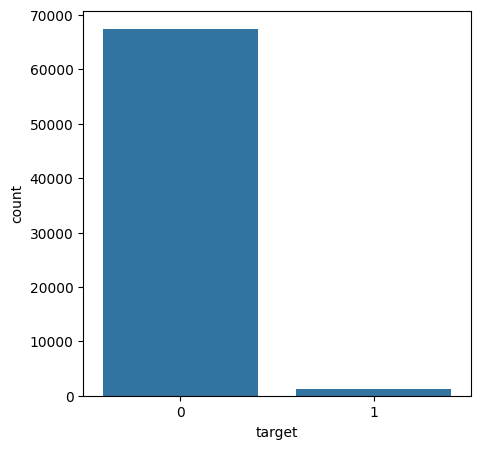

In [39]:
print(df['target'].value_counts())
# 
plt.figure(figsize=(5, 5))
sns.countplot(data=df, x='target')
plt.show()

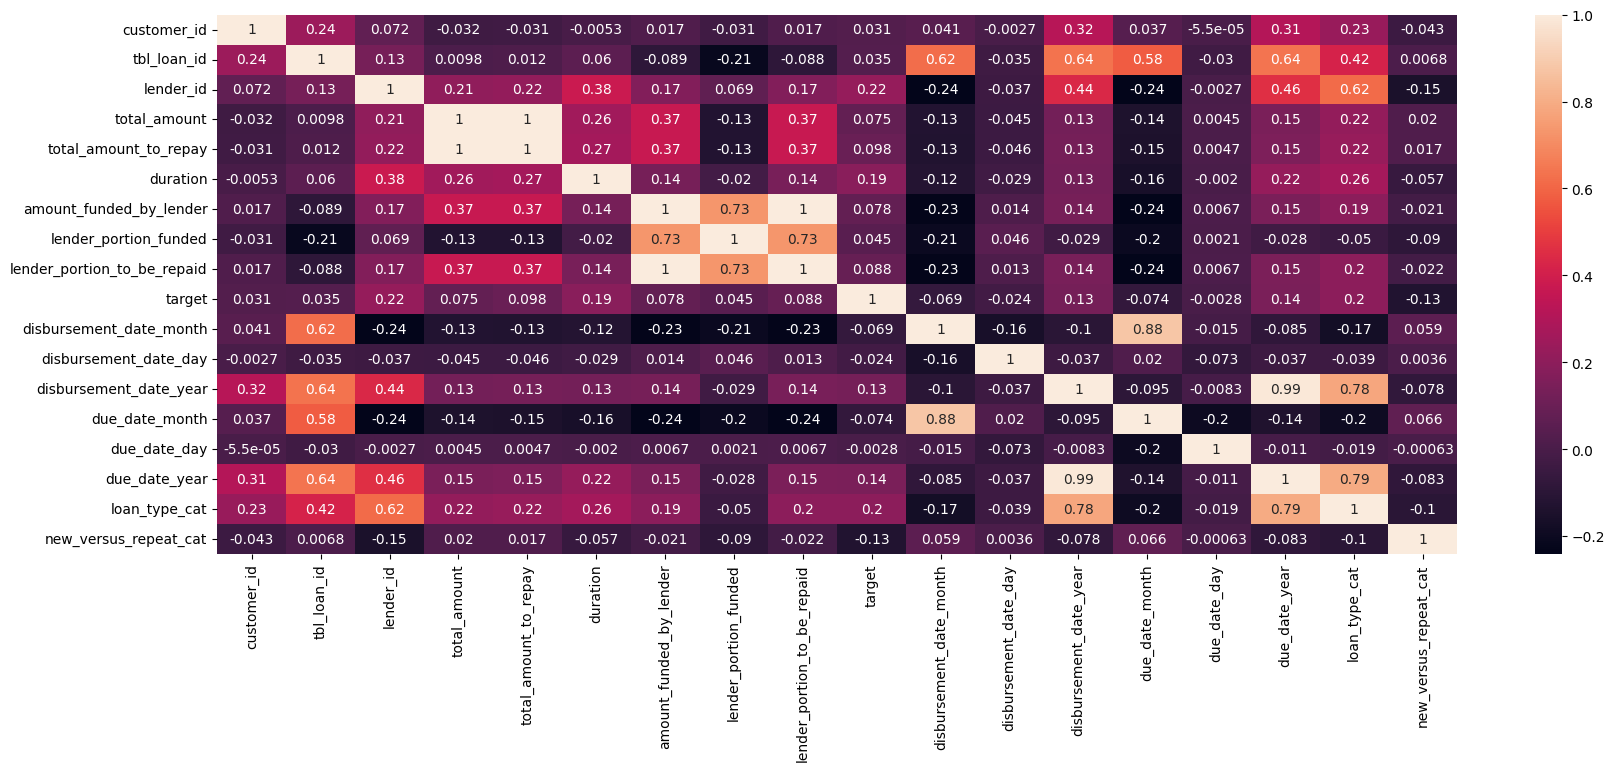

In [40]:
plt.figure(figsize=(20, 7))
sns.heatmap( df.drop(columns=['loan_type','new_versus_repeat']).corr(), annot=True)
# plt.xticks(rotation=30)
plt.show()

# Data Prep

In [41]:
df.head(2)

,customer_id,tbl_loan_id,lender_id,loan_type,total_amount,total_amount_to_repay,duration,new_versus_repeat,amount_funded_by_lender,lender_portion_funded,lender_portion_to_be_repaid,target,disbursement_date_month,disbursement_date_day,disbursement_date_year,due_date_month,due_date_day,due_date_year,loan_type_cat,new_versus_repeat_cat
0,266671,248032,0,type_1,9.041803,9.041803,7,repeat loan,4.802791,0.014305,4.804021,0,8,30,2022,9,6,2022,0,1
1,248919,228515,0,type_1,10.161844,10.165082,7,repeat loan,8.957961,0.300000,8.961238,0,7,30,2022,8,6,2022,0,1


In [42]:
X = df.drop(columns=['target', 
                     'loan_type', 
                     'new_versus_repeat', 
                    #  'lender_id', 
                     'disbursement_date_year',
                     'lender_portion_funded', 
                    #  'duration',
                     
                    #  'due_date_year', 
                    #  'due_date_day', 
                    #  'disbursement_date_day'
                     ])
Y = df['target']
print(X.shape, Y.shape)
X.head(2)

(68654, 15) (68654,)


,customer_id,tbl_loan_id,lender_id,total_amount,total_amount_to_repay,duration,amount_funded_by_lender,lender_portion_to_be_repaid,disbursement_date_month,disbursement_date_day,due_date_month,due_date_day,due_date_year,loan_type_cat,new_versus_repeat_cat
0,266671,248032,0,9.041803,9.041803,7,4.802791,4.804021,8,30,9,6,2022,0,1
1,248919,228515,0,10.161844,10.165082,7,8.957961,8.961238,7,30,8,6,2022,0,1


In [43]:
features_for_modelling = X.columns
print(list(features_for_modelling.values).__len__())
list(features_for_modelling.values)

15


['customer_id',
 'tbl_loan_id',
 'lender_id',
 'total_amount',
 'total_amount_to_repay',
 'duration',
 'amount_funded_by_lender',
 'lender_portion_to_be_repaid',
 'disbursement_date_month',
 'disbursement_date_day',
 'due_date_month',
 'due_date_day',
 'due_date_year',
 'loan_type_cat',
 'new_versus_repeat_cat']

In [44]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, random_state=42)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((65221, 15), (65221,), (3433, 15), (3433,))

In [45]:
print("TARGET TRAIN")
y_train.value_counts()

TARGET TRAIN


target
0    64026
1     1195
Name: count, dtype: int64

In [46]:
print("TARGET TEST")
y_test.value_counts()

TARGET TEST


target
0    3370
1      63
Name: count, dtype: int64

# Imblearn

### Smote

In [47]:
print("dataset size: ", x_train.shape, y_train.shape)
print("\n", y_train.value_counts())


# over sample minority dataset
desired_ratio = 0.5  # e.g., 20% of the majority class
target_minority_count = int(60653 * desired_ratio)
# 
# smote = SMOTE(random_state=42, sampling_strategy={0: 60653, 1: target_minority_count}) # minority
smote = SMOTE(random_state=42, sampling_strategy="minority") # minority
x_smote, y_smote = smote.fit_resample(x_train, y_train)
print("\nSMOTE over sampled:", x_smote.shape, y_smote.shape )
y_smote.value_counts()

dataset size:  (65221, 15) (65221,)

 target
0    64026
1     1195
Name: count, dtype: int64

SMOTE over sampled: (128052, 15) (128052,)


target
0    64026
1    64026
Name: count, dtype: int64

### Adasyn

In [48]:
print("dataset size: ", x_train.shape, y_train.shape)
print("\n", y_train.value_counts())

adasyn = ADASYN(random_state=42, sampling_strategy='minority') # minority
x_adasyn, y_adasyn = adasyn.fit_resample(x_train, y_train)
print( "ADASYN over sampling:", x_adasyn.shape, y_adasyn.shape )
y_adasyn.value_counts()

dataset size:  (65221, 15) (65221,)

 target
0    64026
1     1195
Name: count, dtype: int64
ADASYN over sampling: (127972, 15) (127972,)


target
0    64026
1    63946
Name: count, dtype: int64

### Smote Tomek

In [49]:
print("dataset size: ", x_train.shape, y_train.shape)
print("\n", y_train.value_counts())

smt = SMOTETomek(random_state=42, tomek=TomekLinks(), sampling_strategy='all') # not majority not minority all
x_tomek, y_tomek = smt.fit_resample(x_train, y_train)
print( "SMOTE TOMEK:", x_tomek.shape, y_tomek.shape ) 
y_tomek.value_counts()

dataset size:  (65221, 15) (65221,)

 target
0    64026
1     1195
Name: count, dtype: int64
SMOTE TOMEK: (125756, 15) (125756,)


target
0    64026
1    61730
Name: count, dtype: int64

# Models

### XGB

In [50]:
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# # for class imbalance
pos = np.sum(Y==1)
neg = np.sum(Y==0)
class_pos_weight = neg / pos

In [51]:
# xgb_clf = XGBClassifier(
#   objective='binary:logistic',
#   eval_metric=['logloss', 'auc', 'error'],
#   random_state=42,
# )

# # parameter for grid search
# param_grid = {
#     'n_estimators': [500, 700, 800],
#     'max_depth': [5, 7, 9],
#     'gamma': [0.2, 0.3, 0.5],  # minimum loss reduction for partition

#     'learning_rate': [0.1, 0.2, 0.4],
#     'reg_lambda': [0.1, 0.5, 1],  # L2 regularization

#     'subsample': [0.6, 0.7, 0.8, 1.0], # ratio for training data
#     'colsample_bytree': [0.8, 1.0], # sampling ratio for column
#     'scale_pos_weight': [class_pos_weight, 2 * class_pos_weight, 3 * class_pos_weight]  # control balance of positive and negative weights
# }

# # grid search cv
# grid_search = GridSearchCV(
#     estimator=xgb_clf,
#     param_grid=param_grid,
#     refit="f1", # use to select best model
#     scoring='f1',  #  metric 
#     cv=skfold, # number of folds in cross-validation
#     n_jobs=-1,  # use all cores
#     return_train_score=True  # get training scores to diagnose overfitting
# )

# # fit model with grid search
# grid_search.fit(X, Y)

# # best params, score and model
# best_params = grid_search.best_params_ 
# best_score = grid_search.best_score_
# print("Best Parameters:", best_params)
# print("Best Cross-Validation Score:", best_score)
# print("Best Model:", grid_search.best_estimator_ )

In [52]:
x_train.head(2)

,customer_id,tbl_loan_id,lender_id,total_amount,total_amount_to_repay,duration,amount_funded_by_lender,lender_portion_to_be_repaid,disbursement_date_month,disbursement_date_day,due_date_month,due_date_day,due_date_year,loan_type_cat,new_versus_repeat_cat
1180,259560,295027,0,10.151792,10.181763,7,8.947910,8.977904,11,7,11,14,2022,0,1
32085,254417,224873,0,7.603898,7.628031,7,6.401088,6.424869,7,26,8,2,2022,0,1


In [53]:
# {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 400, 'subsample': 1.0}

class_pos_weight = float(2*class_pos_weight)

xgb = XGBClassifier(

  random_state=42,
  objective='binary:logistic', # binary classification
  eval_metric=['logloss', 'auc'],

  n_estimators=1000, # 700
  max_depth=7, # 5
  gamma=0.2,

  learning_rate=0.2, # 0.2 0.4 0.5
  reg_lambda=0.2, # L2
  # reg_alpha=0.2, # L1

  colsample_bytree=1.0,
  subsample=1.0,
  scale_pos_weight=float(2 * class_pos_weight) # control balance of positive and negative weights

  # 
  
)

# xgb.fit(X, Y)
xgb.fit(x_train, y_train)
# xgb.fit(x_smote, y_smote)
# xgb.fit(x_adasyn, y_adasyn)
# xgb.fit(x_tomek, y_tomek)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['logloss', 'auc'],
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

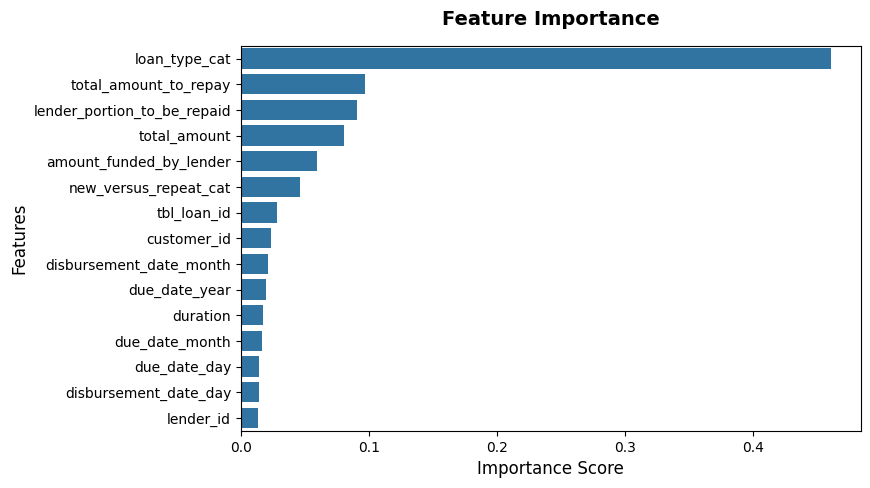

In [54]:
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb.feature_importances_
})
# Sort by importance score in descending order
rf_features = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(data=rf_features, x='Importance', y='Feature')
plt.title('Feature Importance', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

In [55]:
ypred = xgb.predict(x_test)

In [56]:
print(
  classification_report(y_test, ypred, zero_division=1)
)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3370
           1       0.78      0.86      0.82        63

    accuracy                           0.99      3433
   macro avg       0.89      0.93      0.91      3433
weighted avg       0.99      0.99      0.99      3433



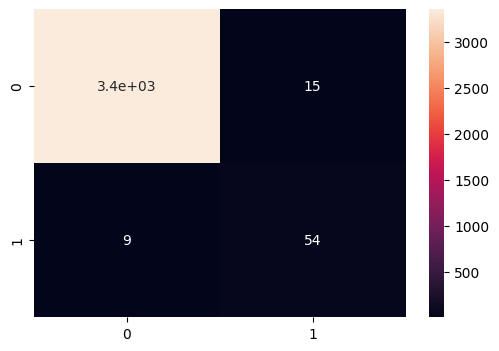

In [57]:
plt.figure(figsize=(6, 4))
conf = confusion_matrix(y_test, ypred)
sns.heatmap(conf, annot=True)
plt.show()

#### CV

In [58]:
scores = cross_val_score(xgb, X, Y, cv=skfold, scoring='f1')

print("F1 for folds: ", scores)
print("Mean F1: ",scores.mean())

F1 for folds:  [0.82170543 0.74725275 0.8164794  0.82575758 0.84732824 0.77394636
 0.78326996 0.81180812 0.78884462 0.83969466]
Mean F1:  0.8056087112604903


### Cat Boost

In [59]:
train_df.head()

,customer_id,tbl_loan_id,lender_id,loan_type,total_amount,total_amount_to_repay,duration,new_versus_repeat,amount_funded_by_lender,lender_portion_funded,lender_portion_to_be_repaid,target,disbursement_date_month,disbursement_date_day,disbursement_date_year,due_date_month,due_date_day,due_date_year
0,266671,248032,267278,type_1,8448.0,8448.0,7,repeat loan,120.85,0.014305,121.0,0,8,30,2022,9,6,2022
1,248919,228515,267278,type_1,25895.0,25979.0,7,repeat loan,7768.50,0.300000,7794.0,0,7,30,2022,8,6,2022
2,308486,370501,251804,type_7,6900.0,7142.0,7,repeat loan,1380.00,0.200000,1428.0,0,9,6,2024,9,13,2024
3,266004,285009,267278,type_1,8958.0,9233.0,7,repeat loan,2687.40,0.300000,2770.0,0,10,20,2022,10,27,2022
4,253803,305312,267278,type_1,4564.0,4728.0,7,repeat loan,1369.20,0.300000,1418.0,0,11,28,2022,12,5,2022


In [60]:
# catboost_pool_train = Pool(x_train, y_train)
# catboost_pool_test = Pool(x_test, y_test)

# model = CatBoostClassifier(
#   iterations=10000,
#   depth=16,
#   learning_rate=0.01,
#   l2_leaf_reg=0.2,
#   loss_function='Logloss',
#   verbose=False
# )
# # train the model
# model.fit(catboost_pool_train)
# # model.fit(x_train, y_train)
# # model.fit(x_adasyn, y_adasyn)
# # model.fit(x_smote, y_smote)
# # model.fit(x_tomek, y_tomek)

# # make the prediction using the resulting model
# catb_pred = model.predict(catboost_pool_test)

# print(classification_report(y_test, catb_pred, zero_division=1))

# # # 
# plt.figure(figsize=(6, 4))
# conf = confusion_matrix(y_test, catb_pred)
# sns.heatmap(conf, annot=True)
# plt.show()

In [61]:
# date_ = timeNow()
# name = f"catboost_{date_}.cbm"
# model.save_model(f"./models/{name}")

### TabPFN

In [62]:
# # Initialize the TabPFN classifier
# # N_ensemble_configurations controls the number of model predictions that are ensembled.
# # classifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=32)
# classifier = TabPFNClassifier(device='cpu', n_estimators=5, random_state=18, ignore_pretraining_limits=True)

# # Fit the model on the training data
# classifier.fit(x_train, y_train)

# # Make predictions
# y_eval, p_eval = classifier.predict(x_test, return_winning_probability=True)
# y_eval, p_eval

In [63]:
# print(
#   classification_report(y_test, y_eval, zero_division=1)
# )

In [64]:
# plt.figure(figsize=(6, 4))
# conf = confusion_matrix(y_test, y_eval)
# sns.heatmap(conf, annot=True)
# plt.show()

In [65]:
# # Assuming 'TuneTables' is a class handling large datasets by chunking
# class TuneTables:
#     def __init__(self, chunk_size=1000):
#         self.chunk_size = chunk_size
#         self.models = []

#     def fit(self, X, y):
#         for i in range(0, len(X), self.chunk_size):
#             X_chunk = X[i:i+self.chunk_size]
#             y_chunk = y[i:i+self.chunk_size]
#             clf = TabPFNClassifier(device='cpu',  n_estimators=5, random_state=18)
#             clf.fit(X_chunk, y_chunk)
#             self.models.append(clf)

#     def predict(self, X):
#         predictions = []
#         for chunk in np.array_split(X, len(X) // self.chunk_size + 1):
#             preds = [model.predict(chunk) for model in self.models]
#             # Here you would need a strategy to aggregate predictions, e.g., voting or averaging
#             predictions.append(np.array(preds).mean(axis=0))
#         return np.concatenate(predictions)

# # 
# tunetables = TuneTables(chunk_size=1000)  # Adjust chunk_size as needed
# tunetables.fit(x_train, y_train)
# y_pred = tunetables.predict(x_test)

# print(
#   classification_report(y_test, y_pred, zero_division=1)
# )

In [66]:
# import math
# num = 1000
# s = 0.0
# for k in range(num):
#   n = (np.pi**k) * ((np.log(np.pi))**k)
#   d = math.factorial(k)
#   print(d, n)
#   s += float(n) / float(d)
# s

### LGM

In [67]:
# params = {
#     'objective': 'binary',
#     # 'num_class': y_train.unique().__len__(),
#     'metric': 'binary_logloss',
#     'boosting_type': 'gbdt',
#     'learning_rate': 0.1,
#     'num_leaves': 31,
#     'max_depth': -1,
#     'verbosity': -1,
#     'is_unbalance': True,
# }

# d_train = lgb.Dataset(x_train, label=y_train)

# num_round = 200
# bst = lgb.train(params, d_train, num_round)
# bst

In [68]:
# y_pred = bst.predict(x_test)
# y_pred_max = [np.argmax(row) for row in y_pred]  # convert probabilities to class labels
# y_pred_max.__len__(), y_test.shape

In [69]:
# print(classification_report(y_test, y_pred_max, zero_division=1))

In [70]:
# plt.figure(figsize=(6, 4))
# sns.heatmap(confusion_matrix(y_test, y_pred_max), annot=True)
# plt.show()

### RF

In [71]:
# # Create a pipeline that first oversamples the minority class and then undersamples the majority class
# rf_model = RandomForestClassifier( max_depth=5, n_estimators=500, class_weight='balanced', random_state=42)

# # Train the model
# rf_model.fit(x_train, y_train)

# # Predict on the test set
# y_pred = rf_model.predict(x_test)

# # Evaluate the model
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred))

# print("\nClassification Report:")
# print(classification_report(y_test, y_pred, zero_division=1))

# Submission

In [72]:
# https://zindi.africa/competitions/african-credit-scoring-challenge
test_df[features_for_modelling].head(2)

,customer_id,tbl_loan_id,lender_id,total_amount,total_amount_to_repay,duration,amount_funded_by_lender,lender_portion_to_be_repaid,disbursement_date_month,disbursement_date_day,due_date_month,due_date_day,due_date_year,loan_type_cat,new_versus_repeat_cat
0,269404,226088,0.0,7.560080,7.595890,7,6.357322,6.393591,7,27,8,3,2022,0,1
1,255356,300042,0.0,7.668094,7.675082,7,0.000000,0.000000,11,16,11,23,2022,0,1


In [73]:
# make predictions on the test dataset
test_predictions = xgb.predict(test_df[features_for_modelling])
# test_predictions = model.predict(test_df[features_for_modelling])
# test_predictions_proba = xgb.predict_proba(test_df[features_for_modelling])[:, 1]
# 
# save the predictions to a CSV file
test_df['target'] = test_predictions
test_df.head()

,id,customer_id,country_id,tbl_loan_id,lender_id,loan_type,total_amount,total_amount_to_repay,duration,new_versus_repeat,amount_funded_by_lender,lender_portion_funded,lender_portion_to_be_repaid,disbursement_date_month,disbursement_date_day,disbursement_date_year,due_date_month,due_date_day,due_date_year,loan_type_cat,new_versus_repeat_cat,target
0,id_269404226088267278,269404,kenya,226088,0.0,type_1,7.560080,7.595890,7,repeat loan,6.357322,0.300000,6.393591,7,27,2022,8,3,2022,0,1,0
1,id_255356300042267278,255356,kenya,300042,0.0,type_1,7.668094,7.675082,7,repeat loan,0.000000,0.000000,0.000000,11,16,2022,11,23,2022,0,1,0
2,id_257026243764267278,257026,kenya,243764,0.0,type_1,9.018574,9.024613,7,repeat loan,5.337538,0.025079,5.342334,8,24,2022,8,31,2022,0,1,0
3,id_264617299409267278,264617,kenya,299409,0.0,type_1,8.125631,8.125631,7,repeat loan,6.922348,0.300000,6.922644,11,15,2022,11,22,2022,0,1,0
4,id_247613296713267278,247613,kenya,296713,0.0,type_1,4.795791,4.795791,7,repeat loan,3.610918,0.300000,3.610918,11,10,2022,11,17,2022,0,1,0


In [74]:
test_df['country_id'].unique()

array(['kenya', 'ghana'], dtype=object)

In [ ]:
# # type all type_3 to have target of 1
# test_df.loc[test_df['country_id'] == 'ghana', 'target'] = 1
# test_df.head()

In [76]:
sub =  test_df[['id', 'target']]
# 
sub = sub.rename(columns={'id': "ID"})
sub['ID'] = sub['ID'].str.upper()
print(sub['target'].value_counts())
sub.head()

target
0    17972
1      622
Name: count, dtype: int64


,ID,target
0,ID_269404226088267278,0
1,ID_255356300042267278,0
2,ID_257026243764267278,0
3,ID_264617299409267278,0
4,ID_247613296713267278,0


In [77]:
# 737 - 762
sub.to_csv('baseline_submission.csv', index=False)